In [1]:
# Code aus "Neuronale Netze selbst programmieren,
# ein verständlicher Einstieg mit Python"
# von Tariq Rashid , O'Reilly
# license GPLv2

import numpy
# scipy.special for the sigmoid function expit()
import scipy.special
import matplotlib.pyplot
%matplotlib inline
import os

In [2]:
# neural network class definition
class neuralNetwork:

    # initialise the neural network
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        # set number of nodes in each inpzt, hidden oputput layer
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes

        # learning rate
        self.lr = learningrate

        # link weight matrices, wih and who 
        # weights inside the arrays aer w_i_j, where link is from node i to node j in the next layer
        self.wih = numpy.random.normal(0.0, pow(self.hnodes, -0.5), (self.hnodes, self.inodes))
        self.who = numpy.random.normal(0.0, pow(self.onodes, -0.5), (self.onodes, self.hnodes))
        
        # acitivation function is the sigmoid funciton
        self.activation_function = lambda x: scipy.special.expit(x)
    
        pass
    
    # train the neural network
    def train(self, inputs_list, targets_list):
        # convert inputs list to 2d array
        inputs = numpy.array(inputs_list, ndmin=2).T
        targets = numpy.array(targets_list, ndmin=2).T
        
        # calculate signals into hidden layer
        hidden_inputs = numpy.dot(self.wih, inputs)
        # calculate the signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # calculate signals into final output layer
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)
        
        # output layer error is the (target - actual)
        output_errors = targets - final_outputs
        # hidden layer error is the output_errors, split by weights, recombined at hidden nodes
        hidden_errors = numpy.dot(self.who.T, output_errors)
        
        # update the weights for the links between the hidden and output layers
        self.who += self.lr * numpy.dot((output_errors * final_outputs * (1.0 - final_outputs)), numpy.transpose(hidden_outputs))
        
        # update the weights for the links between the input and hidden layers
        self.wih += self.lr * numpy.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), numpy.transpose(inputs))
        
        pass

    # query the neural network
    def query(self, inputs_list):
        # convert inputs list to 2d array
        inputs = numpy.array(inputs_list, ndmin=2).T
        
        # calculate signals into hidden layer        
        hidden_inputs = numpy.dot(self.wih, inputs)
        # calculate the signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)      
        
        # calculate signals final output layer        
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # calculate the signals emerging final output layer
        final_outputs = self.activation_function(final_inputs)
        
        return final_outputs


In [3]:
# number of input, hidden and output nodes
input_nodes = 784
hidden_nodes = 100
output_nodes = 10

# learning rate
learning_rate = 0.3

# create instance of neural network
n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

In [4]:
# https://stackoverflow.com/questions/7165749/open-file-in-a-relative-location-in-python
# relative path to files
fileDir = os.path.dirname(os.path.realpath('__file__'))
#For accessing the file in the parent folder of the current folder
training_data_path = os.path.join(fileDir, '../../trainingdata/testdata_mnist/mnist_train_100.csv')
test_data_path = os.path.join(fileDir, '../../trainingdata/testdata_mnist/mnist_test_10.csv')

In [5]:
# load mnist training csv file into a list
training_data_file = open(training_data_path, 'r')
training_data_list = training_data_file.readlines()
training_data_file.close()

In [6]:
# train the neural network
# go through all records in the training data set
for record in training_data_list:
    # split the record by the ',' commas
    all_values = record.split(',')
    # scale input to range 0.01 to 1.00
    inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
    # create the target output values (all 0.01, except the desired label which is 0.99)
    targets = numpy.zeros(output_nodes) + 0.01
    # all_values[0] is the target label for this record
    targets[int(all_values[0])] = 0.99
    n.train(inputs, targets)
    pass

In [10]:
# load mnist training csv file into a list
test_data_file = open(test_data_path, 'r')
test_data_list = test_data_file.readlines()
test_data_file.close()

In [12]:
#get the first test record
all_values = test_data_list[0].split(',')
# print the label
print(all_values[0]) 

7


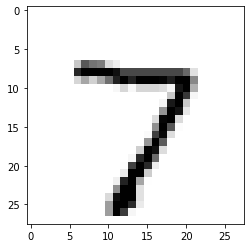

In [15]:
image_array = numpy.asfarray(all_values[1:]).reshape((28,28))
matplotlib.pyplot.imshow(image_array, cmap='Greys', interpolation='None')

In [23]:
n.query((numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01)

array([[0.16327927],
       [0.00275645],
       [0.01680317],
       [0.05863124],
       [0.08347604],
       [0.06286353],
       [0.00225053],
       [0.83300121],
       [0.04762837],
       [0.02847754]])